# MNIST
Make a performance table of MNIST classification neural networks (NN) with different number of layers (at least 2 trials). Repeat it using different activation functions such as sigmoid, hyperbolic tangent, and ReLU. 

using GPU : True
CUDA:0 (NVIDIA TITAN RTX, 24575.5625MB)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])
{'0 - zero': 0, '1 - one': 1, '2 - two': 2, '3 - three': 3, '4 - four': 4, '5 - five': 5, '6 - six': 6, '7 - seven': 7, '8 - eight': 8, '9 - nine': 9}
60000
Case03(
  (linear): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)
model evaluation
Accuracy: 9749/10000 (97.5 %)
79510


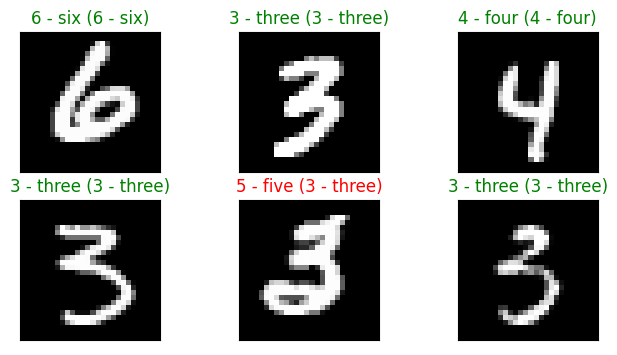

In [8]:
import os
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

BATCH_SIZE = 32
DEVICE = "0" # 'cpu' or '0' or '0,1,2,3'
LR = 1e-3
EPOCH = 5
model_mode = "eval" # 'train' or 'eval'
model_type = "Case03"
save_model_path = f"C:\\Users\\yuncs\\Desktop\\checkpoint\\{model_type}.pt"

def select_device(DEVICE, BATCH_SIZE):
    flag_device = DEVICE.lower() == "cpu"
    if flag_device:
        os.environ['CUDA_VISIBLE_DEVICE'] = "-1"
    else:
        os.environ['CUDA_VISIBLE_DEVICE'] = DEVICE
        assert torch.cuda.is_available(), f"CUDA unavailable, invaild device {DEVICE} requested"
    print("using GPU :", not flag_device and torch.cuda.is_available())

    flag_cuda = not flag_device and torch.cuda.is_available()
    if flag_cuda:
        num_cuda = torch.cuda.device_count()
        if num_cuda > 1 and BATCH_SIZE:
            assert BATCH_SIZE % num_cuda == 0, f"Batch size {BATCH_SIZE} not multiple of GPU count {num_cuda}"
        for i, val in enumerate(DEVICE.split(",")):
            p = torch.cuda.get_device_properties(i)
            print(f"CUDA:{val} ({p.name}, {p.total_memory / 1024 ** 2}MB)\n")
    return torch.device('cuda' if flag_cuda else "cpu")

def Train(model, train_x, criterion, optimer, epoch, device):
    history_loss =[]
    num_train = len(train_x.dataset)

    model.train() # change train mode
    for ep in range(epoch):
        loss_ep = 0 # epoch loss
        for batch_x, batch_y in train_x:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            y_h = model(batch_x) # inference
            loss = criterion(y_h, batch_y) # loss
            optimer.zero_grad()
            loss.backward() # backpropagation
            optimer.step() # weight update
            # loss history
            loss_batch = loss.item() * batch_x.shape[0]
            loss_ep += loss_batch # add batch loss
        # print loss
        loss_ep = loss_ep/num_train
        history_loss += [loss_ep]
        print(f"Epoch: {ep+1}, train loss: {round(loss_ep, 3)}")
    
    return history_loss

def Eval(model, test_x, device):
    model.eval() # change eval mode
    with torch.no_grad():
        true_total = 0
        for batch_x, batch_y in test_x:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            y_h = model(batch_x) # inference
            predict = y_h.argmax(dim=1) # add batch accuracy
            true_batch = torch.sum(predict == batch_y).item()
            true_total += true_batch
        accuracy_e = true_total/len(test_x.dataset)*100
    print(f"Accuracy: {true_total}/{len(test_x.dataset)} ({round(accuracy_e,1)} %)")

    batch_x = batch_x.to("cpu")
    plt.figure(figsize=(8,4))
    for idx in range(6):
        plt.subplot(2,3, idx+1, xticks=[], yticks=[])
        plt.imshow(batch_x[idx].permute(1,2,0).squeeze(), cmap="gray")
        pred_class = test_x.dataset.classes[predict[idx]]
        true_class = test_x.dataset.classes[batch_y[idx]]
        plt.title(f"{pred_class} ({true_class})", color = "g" if pred_class==true_class else "r")     


device = select_device(DEVICE, BATCH_SIZE)

# dataset load
transform = transforms.ToTensor()
train_X = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_X = datasets.MNIST(root='data', train=False, download=True, transform=transform)
print(train_X.data.shape, test_X.data.shape)
print(train_X.class_to_idx)
train_x = DataLoader(train_X, batch_size=BATCH_SIZE, shuffle=True)
test_x = DataLoader(test_X, batch_size=BATCH_SIZE, shuffle=True)
print(len(train_x.dataset))

# create model
class Case01(nn.Module):
    def __init__(self):
        super().__init__()
    
        self.linear = nn.Sequential(nn.Linear(28*28, 30),
                                    nn.Sigmoid(),
                                    nn.Linear(30, 80),
                                    nn.Sigmoid(),
                                    nn.Linear(80, 100),
                                    nn.Sigmoid(),
                                    nn.Linear(100, 10))
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.linear(x)
        return x

class Case02(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear = nn.Sequential(nn.Linear(28*28, 100),
                                    nn.Tanh(),
                                    nn.Linear(100, 10))

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.linear(x)
        return x

class Case03(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear = nn.Sequential(nn.Linear(28*28, 100),
                                    nn.ReLU(),
                                    nn.Linear(100,10))

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.linear(x)
        return x

exec(f"model = {model_type}().to(device)")
print(model)

if model_mode == 'train':
    print('model train')
    optimer = optim.Adam(model.parameters(), lr=LR)
    show_loss = Train(model, train_x, nn.CrossEntropyLoss(), optimer, EPOCH, device)
    torch.save(model, save_model_path)
    plt.plot(range(0,EPOCH), show_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title(f'{model_type} Train Loss')
    plt.grid()
elif model_mode == 'eval':
    print('model evaluation')
    load_model = torch.load(save_model_path, map_location=device)
    Eval(load_model, test_x, device)
    print(sum([p.numel() for p in load_model.parameters() if p.requires_grad]))

# Compare performance between logistic regression models and neural networks with several layers using a provided diabetes dataset. Access to the data using the code below. 

using GPU : True
CUDA:0 (NVIDIA TITAN RTX, 24575.5625MB)

(768, 8) (768,)
torch.Size([614, 8]) torch.Size([154, 8]) torch.Size([614, 1]) torch.Size([154, 1])
LogisticRegression(
  (linear): Sequential(
    (0): Linear(in_features=8, out_features=1, bias=True)
    (1): Sigmoid()
  )
)
model train
Epoch: 1, train loss: 10.104
Epoch: 2, train loss: 3.346
Epoch: 3, train loss: 1.228
Epoch: 4, train loss: 0.819
Epoch: 5, train loss: 0.693
Epoch: 6, train loss: 0.655
Epoch: 7, train loss: 0.619
Epoch: 8, train loss: 0.651
Epoch: 9, train loss: 0.675
Epoch: 10, train loss: 0.672
Epoch: 11, train loss: 0.639
Epoch: 12, train loss: 0.691
Epoch: 13, train loss: 0.677
Epoch: 14, train loss: 0.727
Epoch: 15, train loss: 0.657
Epoch: 16, train loss: 0.669
Epoch: 17, train loss: 0.625
Epoch: 18, train loss: 0.695
Epoch: 19, train loss: 0.709
Epoch: 20, train loss: 0.642
Epoch: 21, train loss: 0.682
Epoch: 22, train loss: 0.774
Epoch: 23, train loss: 0.651
Epoch: 24, train loss: 0.659
Epoch: 25, trai

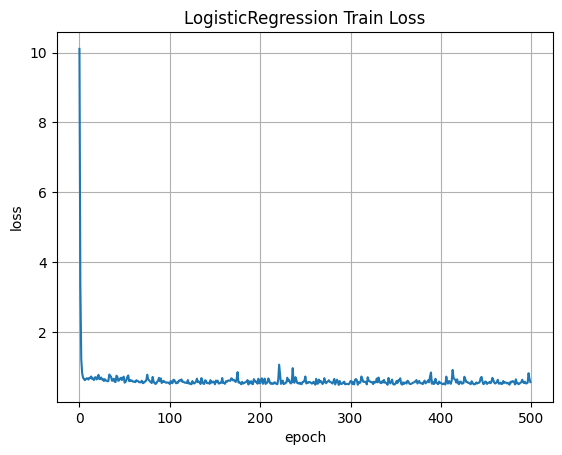

In [10]:
import os
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from numpy import loadtxt

BATCH_SIZE = 16
DEVICE = "0" # 'cpu' or '0' or '0,1,2,3'
LR = 1e-2
EPOCH = 500
model_type = "LogisticRegression" # LogisticRegression or NeuralNetwork
model_mode = "train" # 'train' or 'eval'
save_model_path = f"C:\\Users\\yuncs\\Desktop\\checkpoint\\{model_type}.pt"


def select_device(DEVICE, BATCH_SIZE):
    flag_device = DEVICE.lower() == "cpu"
    if flag_device:
        os.environ['CUDA_VISIBLE_DEVICE'] = "-1"
    else:
        os.environ['CUDA_VISIBLE_DEVICE'] = DEVICE
        assert torch.cuda.is_available(), f"CUDA unavailable, invaild device {DEVICE} requested"
    print("using GPU :", not flag_device and torch.cuda.is_available())

    flag_cuda = not flag_device and torch.cuda.is_available()
    if flag_cuda:
        num_cuda = torch.cuda.device_count()
        if num_cuda > 1 and BATCH_SIZE:
            assert BATCH_SIZE % num_cuda == 0, f"Batch size {BATCH_SIZE} not multiple of GPU count {num_cuda}"
        for i, val in enumerate(DEVICE.split(",")):
            p = torch.cuda.get_device_properties(i)
            print(f"CUDA:{val} ({p.name}, {p.total_memory / 1024 ** 2}MB)\n")
    return torch.device('cuda' if flag_cuda else "cpu")

def Train(model, train_x, criterion, optimer, epoch, device):
    history_loss =[]
    num_train = len(train_x.dataset)
    loss_total = 0

    model.train() # change train mode
    for ep in range(epoch):
        loss_ep = 0 # epoch loss
        for batch_x, batch_y in train_x:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            y_h = model(batch_x) # inference
            loss = criterion(y_h, batch_y) # loss
            optimer.zero_grad()
            loss.backward() # backpropagation
            optimer.step() # weight update
            # loss history
            loss_batch = loss.item() * batch_x.shape[0]
            loss_ep += loss_batch # add batch loss
        # print loss
        loss_ep = loss_ep/num_train
        history_loss += [loss_ep]
        print(f"Epoch: {ep+1}, train loss: {round(loss_ep, 3)}")
        loss_total += loss_ep
    print(loss_total/epoch)
    
    return history_loss

def Eval(model, test_x, device, model_type):
    model.eval() # change eval mode
    with torch.no_grad():
        true_total = 0
        for batch_x, batch_y in test_x:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            y_h = model(batch_x) # inference
            if model_type == 'LogisticRegression':
                predict = (y_h > 0.5).float()
                true_batch = torch.sum(predict == batch_y).item()
            elif model_type == 'NeuralNetwork':
                _, predict = torch.max(y_h, dim=1)
                true_batch = torch.sum(predict == batch_y).item()
            true_total += true_batch
        accuracy_e = true_total/len(test_x.dataset)*100
    print(f"Accuracy: {true_total}/{len(test_x.dataset)} ({round(accuracy_e,1)} %)")

device = select_device(DEVICE, BATCH_SIZE)

# load the dataset
dataset = loadtxt('C:\\Users\\yuncs\\Desktop\\data\\pima-indians-diabetes.csv', delimiter=',')
# split into input (X) and output (y) variables
X = dataset[:,0:8]
y = dataset[:,8]
print(X.shape, y.shape)

# convert tensor & split dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=3, shuffle=True)
#print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
if model_type == 'LogisticRegression':
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    Y_train = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(1)
    Y_test = torch.tensor(Y_test, dtype=torch.float32).unsqueeze(1)
elif model_type == 'NeuralNetwork':
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    Y_train = torch.tensor(Y_train, dtype=torch.int64)
    Y_test = torch.tensor(Y_test, dtype=torch.int64)


print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = TensorDataset(X_test, Y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

class LogisticRegression(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear = nn.Sequential(nn.Linear(8, 1),
                                    nn.Sigmoid())

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.linear(x)
        return x
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear = nn.Sequential(nn.Linear(8, 25),
                                    nn.ReLU(),
                                    nn.Linear(25, 35),
                                    nn.ReLU(),
                                    nn.Linear(35, 2))

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.linear(x)
        return x

exec(f"model = {model_type}().to(device)")
print(model)

if model_mode == 'train':
    print('model train')
    optimer = optim.Adam(model.parameters(), lr=LR)
    if model_type == 'LogisticRegression':
        show_loss = Train(model, train_loader, nn.BCELoss(), optimer, EPOCH, device)
    elif model_type == 'NeuralNetwork':
        show_loss = Train(model, train_loader, nn.CrossEntropyLoss(), optimer, EPOCH, device)
    torch.save(model, save_model_path)
    plt.plot(range(0,EPOCH), show_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title(f'{model_type} Train Loss')
    plt.grid()
elif model_mode == 'eval':
    print('model evaluation')
    load_model = torch.load(save_model_path, map_location=device)
    Eval(load_model, test_loader, device, model_type)

